# Estudio de URLs maliciosas

In [182]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
import seaborn as sns
# Configurar estilo de gráficos
sns.set(style="whitegrid")

In [184]:
df = pd.read_csv('phishing_site_urls.csv')
print(df.head()) 

                                                 URL Label
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....   bad
3  mail.printakid.com/www.online.americanexpress....   bad
4  thewhiskeydregs.com/wp-content/themes/widescre...   bad


Este dataset únicamente incluye dos columnas:
- URL, con las URLs estudiadas.
- Label, donde se clasifica como maliciosa o no la URL.

Este dataset se ha obtenido a través de la plataforma Kaggle, concretamente en https://www.kaggle.com/datasets/taruntiwarihp/phishing-site-urls?resource=download.

# Obteniendo los datos

En esta primera toma de contacto se observa cuáles pueden ser las características más interesantes a estudiar de los enlaces, para realizar un análisis en profundidad mediante gráficos.

#### Palabras más repetidas en los enlaces maliciosos

In [4]:
# Filtrar solo los enlaces maliciosos
malicious_urls = df[df['Label'] == 'bad']['URL']
benign_urls = df[df['Label'] == 'good']['URL']
# Extraer palabras de las URLs
words = []
for url in malicious_urls:
    words.extend(re.findall(r'[a-zA-Z0-9]+', url))  # Extrae palabras y números

# Contar frecuencia de palabras
word_counts = Counter(words)
print(word_counts.most_common(20))  # Top 20 palabras más usadas


[('com', 99293), ('php', 37367), ('amp', 33182), ('www', 22463), ('login', 22127), ('net', 19115), ('html', 16128), ('index', 16032), ('wp', 13177), ('paypal', 10224), ('htm', 9662), ('us', 9024), ('battle', 9005), ('en', 8697), ('1', 8330), ('cmd', 7472), ('images', 7298), ('org', 6639), ('co', 6597), ('content', 6497)]


#### Longitud de los enlaces maliciosos vs benignos

In [6]:
df['length'] = df['URL'].apply(len)

# Comparar estadísticas
print(df.groupby('Label')['length'].describe())  # Media, mediana, moda, etc.

          count       mean        std  min   25%   50%   75%     max
Label                                                               
bad    156422.0  63.217597  72.013444  1.0  26.0  40.0  72.0  2307.0
good   392924.0  45.767512  24.641329  1.0  30.0  40.0  56.0  1025.0


Las URLs maliciosas tienen una media de longitud de 63.22 caracteres, significativamente más larga que las URLs benignas, que tienen una media de 45.77 caracteres. Además, las URLs maliciosas muestran una mayor desviación estándar (72.01 frente a 24.64), lo que indica que las longitudes de las URLs maliciosas son más variables y pueden incluir URLs extremadamente largas (hasta 2307 caracteres), mientras que las benignas son más consistentes y no superan los 1025 caracteres.

En conclusión, las URLs maliciosas de la muestra tienden a ser más largas y tienen una mayor variabilidad en su longitud en comparación con las URLs benignas de la muestra.

#### Caracteres más utilizados en los enlaces maliciosos

In [8]:
# Extraer solo caracteres no alfanuméricos
non_alphanumeric_chars = re.findall(r'[^a-zA-Z0-9]', "".join(malicious_urls))

# Contar frecuencia de caracteres no alfanuméricos
char_counts = Counter(non_alphanumeric_chars)

# Mostrar los 20 caracteres más frecuentes
print(char_counts.most_common(20))

[('.', 432791), ('/', 429319), ('-', 95340), ('=', 76469), ('&', 45938), ('_', 44495), ('?', 38909), (';', 33278), ('%', 31470), ('\\', 15609), ("'", 7158), (':', 5838), ('+', 3266), ('~', 2092), ('@', 1862), (',', 1290), (' ', 1234), ('#', 369), ('|', 266), ('\u200a', 254)]


#### Dominios más utilizados

In [12]:
df['domain'] = df['URL'].str.extract(r'([a-zA-Z0-9-]+\.[a-z]{2,})')  # Extrae dominio base
print(df[df['Label'] == 'bad']['domain'].value_counts().head(10))  # Top 10 dominios maliciosos

domain
paypal.com                                  1710
9d345009-a-62cb3a1a-s-sites.googlegroups    1527
www.paypal                                   966
pastehtml.com                                957
us.battle                                    725
secure.runescape                             407
twitter.com                                  406
webmail.mhcable                              378
bit.ly                                       312
www.babinet                                  297
Name: count, dtype: int64


#### Palabras sospechosas en enlaces maliciosos

In [143]:
suspicious_words = ['free', 'login', 'verify', 'click', 'win', 'update', "account", "password", "secure"]
for word in suspicious_words:
    count = df[df['Label'] == 'bad']['URL'].str.contains(word, case=False, na=False).sum()
    print(f'La palabra "{word}" aparece en {count} enlaces maliciosos')

La palabra "free" aparece en 1226 enlaces maliciosos
La palabra "login" aparece en 21841 enlaces maliciosos
La palabra "verify" aparece en 840 enlaces maliciosos
La palabra "click" aparece en 727 enlaces maliciosos
La palabra "win" aparece en 1134 enlaces maliciosos
La palabra "update" aparece en 4798 enlaces maliciosos
La palabra "account" aparece en 3910 enlaces maliciosos
La palabra "password" aparece en 127 enlaces maliciosos
La palabra "secure" aparece en 5575 enlaces maliciosos


####  Patrones de números o caracteres aleatorios

In [16]:
df['has_numbers'] = df['URL'].str.contains(r'\d{4,}', regex=True)
print(df.groupby('Label')['has_numbers'].mean())  # % de enlaces con muchos números

Label
bad     0.241814
good    0.318761
Name: has_numbers, dtype: float64


El resultado muestra que un 24.18% de los enlaces maliciosos (bad) contienen muchos números (4 o más dígitos consecutivos), mientras que un 31.88% de los enlaces benignos (good) también tienen números. Esto sugiere que los enlaces maliciosos no presentan un uso significativamente más alto de números que los benignos. Aunque la diferencia es pequeña, no parece que la presencia de muchos números sea un indicador claro de que un enlace sea malicioso, ya que tanto los enlaces maliciosos como benignos pueden contener números en cantidades similares.

#### Extensiones sospechosas maliciosos vs benignos

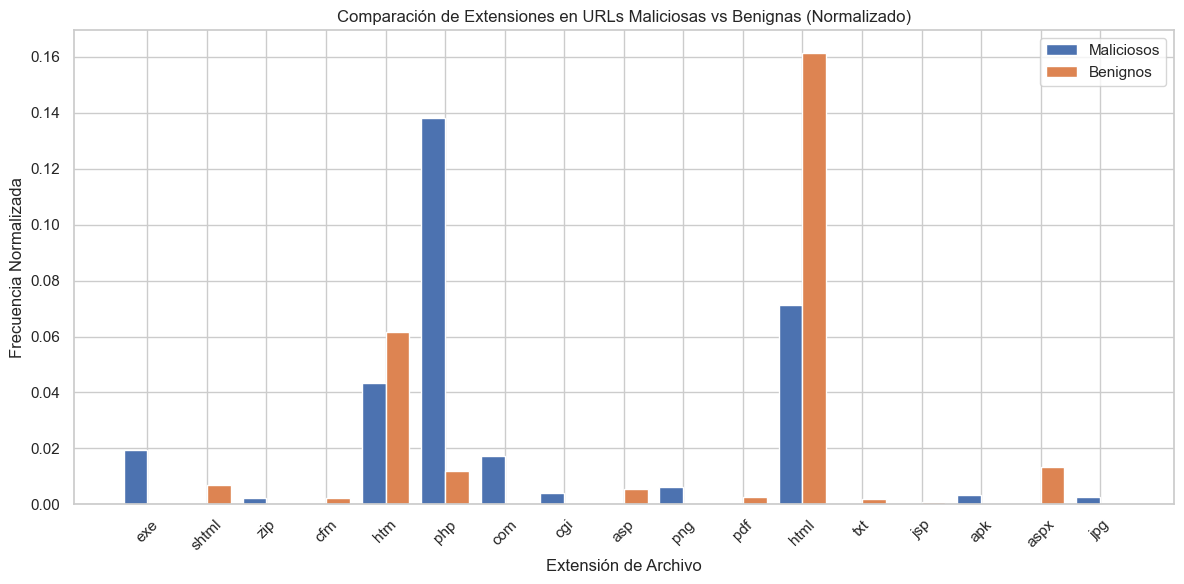

In [135]:
# Extraer las extensiones de los enlaces
df['extension'] = df['URL'].str.extract(r'\.([a-z]{2,5})$')

# Seleccionar las 10 extensiones más comunes en cada categoría
top_malicious = df[df['Label'] == 'bad']['extension'].value_counts().nlargest(10)
top_benign = df[df['Label'] == 'good']['extension'].value_counts().nlargest(10)

# Unir ambos conjuntos de extensiones para comparación
extensions = list(set(top_malicious.index).union(set(top_benign.index)))

# Obtener las frecuencias de estas extensiones en ambas categorías
malicious_freqs = [top_malicious[e] if e in top_malicious else 0 for e in extensions]
benign_freqs = [top_benign[e] if e in top_benign else 0 for e in extensions]

# Normalizar los datos
total_malicious = df[df['Label'] == 'bad'].shape[0]
total_benign = df[df['Label'] == 'good'].shape[0]

malicious_freqs_normalized = [freq / total_malicious for freq in malicious_freqs]
benign_freqs_normalized = [freq / total_benign for freq in benign_freqs]

# Crear gráfico comparativo con los datos normalizados
x = np.arange(len(extensions))
width = 0.4

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, malicious_freqs_normalized, width, label="Maliciosos")
plt.bar(x + width/2, benign_freqs_normalized, width, label="Benignos")
plt.xticks(ticks=x, labels=extensions, rotation=45)
plt.xlabel("Extensión de Archivo")
plt.ylabel("Frecuencia Normalizada")
plt.title("Comparación de Extensiones en URLs Maliciosas vs Benignas (Normalizado)")
plt.legend()
plt.tight_layout()
plt.show()

Brevemente, lo que se observa en este gráfico es que el uso de php y exe es habitual en URLs maliciosas, en contraposición con las extensiones más utilizadas en las benignas, que son html y htm. 

Podría deberse a que estos tipos de archivos son comúnmente utilizados en ataques, como la ejecución de scripts o la distribución de malware. PHP es un lenguaje de servidor que puede ser aprovechado para ejecutar código malicioso en servidores web, mientras que EXE se refiere a archivos ejecutables que pueden contener programas dañinos.

HTML es una extensión común en enlaces benignos porque es el formato estándar de las páginas web, utilizado para la visualización de contenido. Las extensiones HTML y HTM son más comunes en sitios web legítimos y no ejecutan código malicioso por sí mismas.

#### Uso de acortadores de URL en enlaces maliciosos

In [123]:
shorteners = ['bit.ly', 'tinyurl.com', 't.co', 'goo.gl', 'is.gd']
df['is_shortened'] = df['URL'].str.contains('|'.join(shorteners), case=False)
print(df.groupby('Label')['is_shortened'].mean())  # % de enlaces acortados

Label
bad     0.049661
good    0.069858
Name: is_shortened, dtype: float64


En este primer análisis se observa que el porcentaje de uso de acortadores en ambos tipos de enlaces es bajo, por lo que en un principio no parece que vaya a ser determinante a la hora de distinguir un enlace malicioso de uno benigno. Sin embargo, se estudiará más en profundidad con el objetivo de determinar si a pesar de su bajo uso, es una característica diferenciadora de ambas clases.

#### Uso de HTTPS en enlaces maliciosos vs benignos

In [22]:
df['is_https'] = df['URL'].str.startswith('https://')
print(df.groupby('Label')['is_https'].mean())  # % de HTTPS en cada categoría

Label
bad     0.000045
good    0.000000
Name: is_https, dtype: float64


Por los resultados anteriores, se puede deducir que esta información no está presente en los datos y por tanto no se pueden obtener conclusiones sobre si en el caso de los benignos o maliciosos se utiliza más el protocolo HTTP o HTTPS. El objetivo de esta primera exploración era saber si puede resultar relevante en el análisis y posteriormente hacer una comparativa del uso de estos protocolos en cada clase. Dado que no es relevante, se descarta el estudio de esta característica en los datos más en profundidad.

## Graficando los datos

C:\Users\lcgsa\AppData\Local\Temp\ipykernel_5864\330042474.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=df_words, palette="viridis")


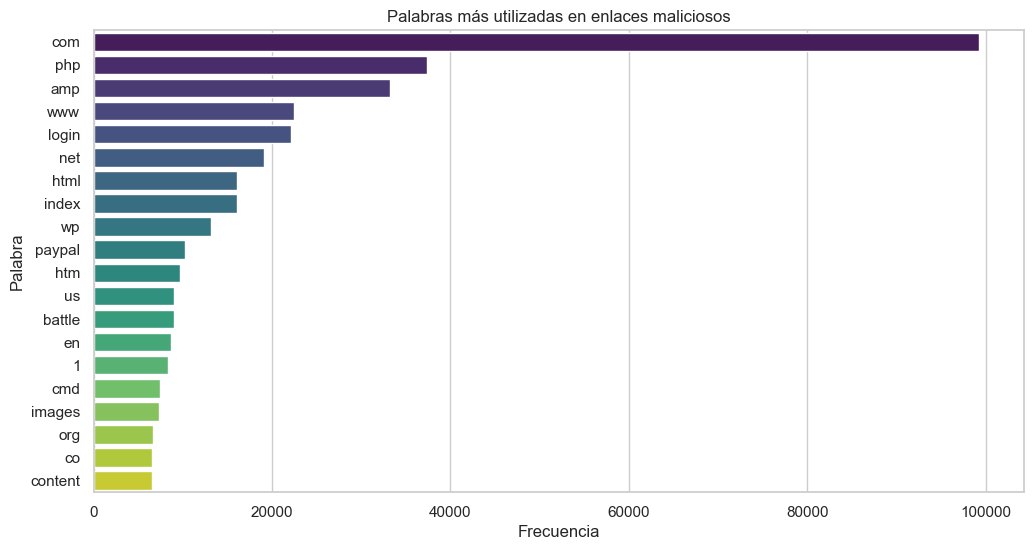

In [24]:
common_words = word_counts.most_common(20)
df_words = pd.DataFrame(common_words, columns=['Word', 'Count'])

# Graficar
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=df_words, palette="viridis")
plt.title("Palabras más utilizadas en enlaces maliciosos")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.show()

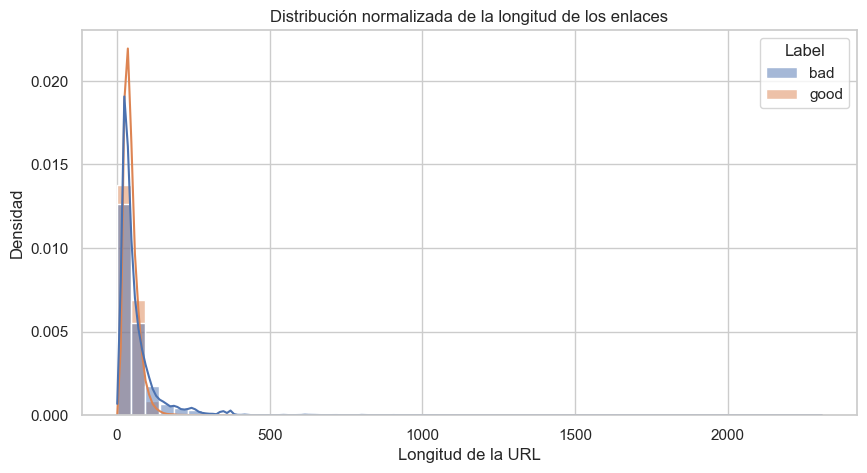

In [37]:
plt.figure(figsize=(10, 5))

ax = sns.histplot(
    data=df, x='length', hue='Label', bins=50, kde=True, 
    stat="density", common_norm=False  # Normaliza por categoría
)

# Obtener las etiquetas correctamente
handles, labels = ax.get_legend_handles_labels()

# Solo mostrar la leyenda si hay etiquetas
if labels:
    plt.legend(handles, labels, title="Tipo de enlace")


plt.title("Distribución normalizada de la longitud de los enlaces")
plt.xlabel("Longitud de la URL")
plt.ylabel("Densidad")
plt.show()

Dado que las clases están desbalanceadas, se han normalizado los datos con el objetivo de ajustarse lo máximo posible a resultados objetivos y ser más preciosos a la hora de realizar un análisis. Como se puede observar, en este gráfico se estudia la distribución de la longitud de los enlaces maliciosos con respecto a los benignos, y vemos que son muy similares, con una asimetría negativa (hacia la izquierda), lo que indica que la media está desplazada hacia valores más bajos. El hecho de que las longitudes sean parecidas puede ser un indicador de que un atacante a la hora de generar un enlace malicioso intenta imitar al máximo las características de una URL benigna para pasar desapercibido y hacer uso de la ingeniería social.

C:\Users\lcgsa\AppData\Local\Temp\ipykernel_2976\610713872.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Character', y='Count', data=df_chars, palette="coolwarm")


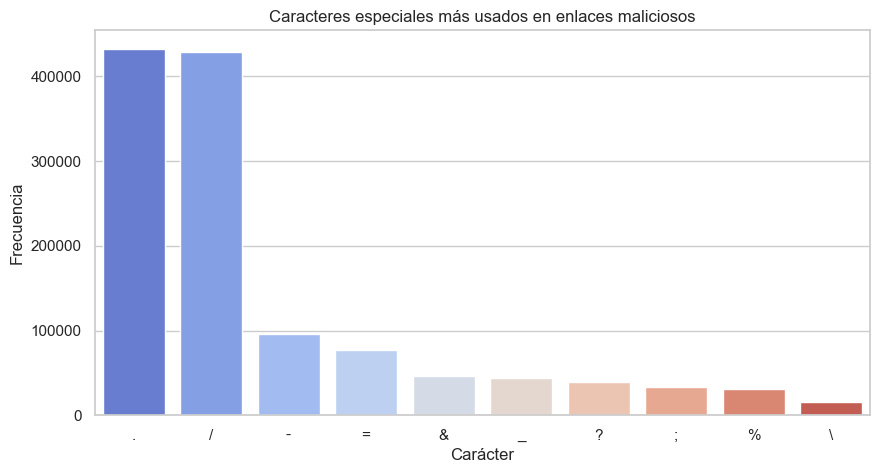

In [33]:
df_chars = pd.DataFrame(char_counts.most_common(10), columns=['Character', 'Count'])
plt.figure(figsize=(10, 5))
sns.barplot(x='Character', y='Count', data=df_chars, palette="coolwarm")
plt.title("Caracteres especiales más usados en enlaces maliciosos")
plt.xlabel("Carácter")
plt.ylabel("Frecuencia")
plt.show()

En los enlaces maliciosos, vemos que es recurrente el uso de algunos caracteres especiales como ".", "/", "-", "="... Aunque habría que entrar más en profundidad a verificar la forma en la que se utilizan estos caracteres, y si alguno se puede utilizar para, por ejemplo, añadir un parámetro no esperado que explote una vulnerabilidad. En este caso, la mayoría de son utilizados habitualmente incluso por caracteres benignos, por lo que a pesar de ser interesante explorarlo, este gráfico no nos ofrece resultados concluyentes. Por este motivo, lo mejor es explorar desde otro punto de vista esta información para ver si nos resulta más útil, comparándolo con el uso que se le da a estos caracteres en los enlaces benignos.

#### Caracteres especiales URL malignos vs benignos

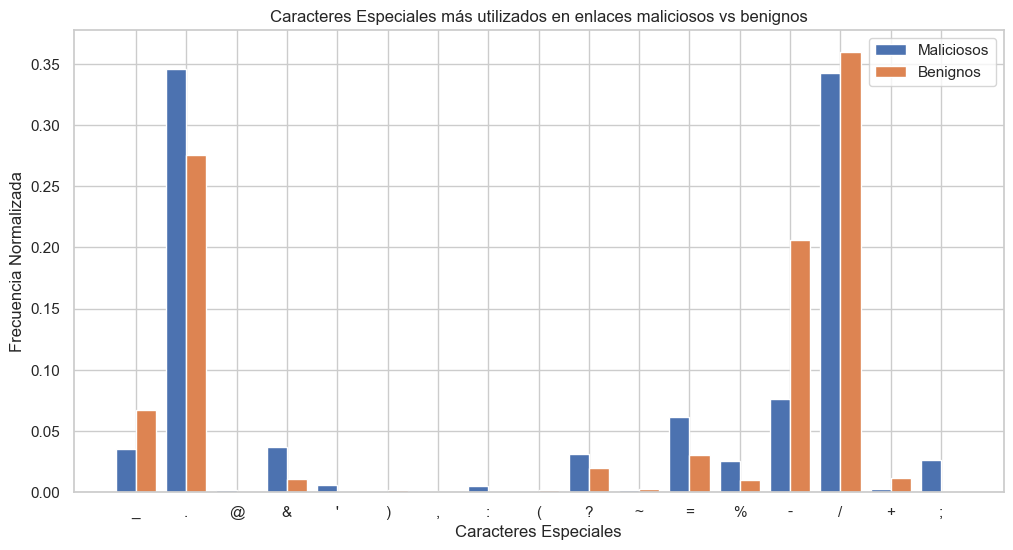

In [173]:
# Normalización de las frecuencias
# Sumar las frecuencias totales de caracteres especiales en ambas clases
total_malicious = sum(char_counts_malicious.values())
total_benign = sum(char_counts_benign.values())

# Normalizar las frecuencias dividiendo por la frecuencia total de cada clase
malicious_freqs_normalized = [char_counts_malicious[c] / total_malicious if c in char_counts_malicious else 0 for c in chars]
benign_freqs_normalized = [char_counts_benign[c] / total_benign if c in char_counts_benign else 0 for c in chars]

# Crear gráfico comparativo
x = np.arange(len(chars))
width = 0.4

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, malicious_freqs_normalized, width, label="Maliciosos")
plt.bar(x + width/2, benign_freqs_normalized, width, label="Benignos")
plt.xticks(ticks=x, labels=chars)
plt.xlabel("Caracteres Especiales")
plt.ylabel("Frecuencia Normalizada")
plt.title("Caracteres Especiales más utilizados en enlaces maliciosos vs benignos")
plt.legend()
plt.show()

Vemos que el uso de "/" es similar en ambos tipos de enlaces, mientras que en el caso de ".", "?", "&" y "=" es más común utilizarlo en enlaces maliciosos. Esta diferencia se podría deber a:
- **"."**: para separar dominios y subdominios, y también en la extensión de archivos como .exe, .zip, utilizando técnicas de ofuscación y en enlaces de descargas.
- **"?"**: para iniciar una cadena de parámetros que podrían estar manipulados por un atacante (inyección de parámetros para realizar ataques SQL injection o cross-site scripting (XSS)). También es posible que se utilice este caracter en enlaces dinámicos para realizar redirecciones o rastrear al usuario, como puede ocurrir en casos de phishing.
- **"&"**: que el signo de interrogación, es un delimitador para añadir múltiples parámetros en una URL. Los atacantes pueden abusar de esto para agregar varios parámetros maliciosos que realicen acciones indeseadas, o incluso utilizarse para obfuscar la URL.
- **"="**: junto con los dos caracteres anteriores, podrían ser utilizados en ataques como XSS o SQL injection ya que se utiliza para asignar valores a los parámetros en la URL. De esta forma, se puede utilizar para asignar valores de redirección o valores manipulados para dirigir a la víctima a páginas de phishing o sitios comprometidos.

Aunque habría que explorar las URL que utilizar estos caracteres más en profundidad y ver si realmente se utilizan para los ataques descritos anteriormente, a simple vista no vemos diferencias significativas entre las dos clases.

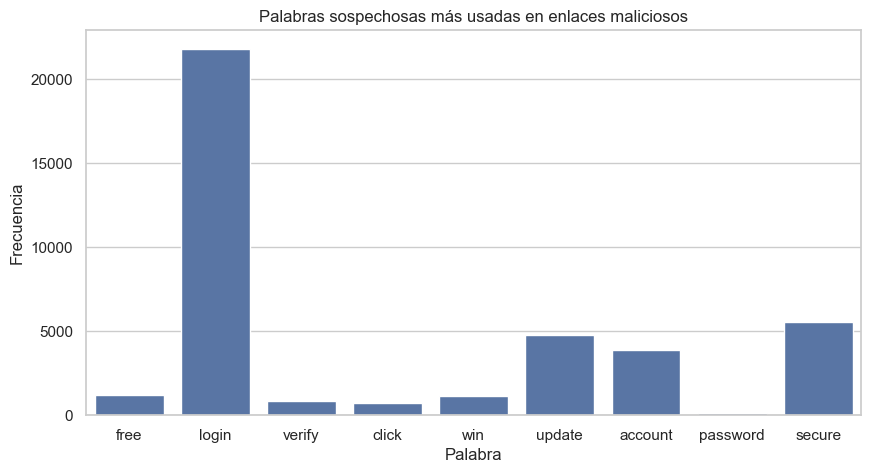

In [111]:
counts = {word: df[df['Label'] == 'bad']['URL'].str.contains(word, case=False, na=False).sum() for word in suspicious_words}

# Convertir a DataFrame
df_suspicious = pd.DataFrame(counts.items(), columns=['Word', 'Count'])

# Graficar
plt.figure(figsize=(10, 5))
sns.barplot(x='Word', y='Count', data=df_suspicious)
plt.title("Palabras sospechosas más usadas en enlaces maliciosos")
plt.xlabel("Palabra")
plt.ylabel("Frecuencia")
plt.show()

Indudablemente, la palabra login se proclama ganadora en el recuento de palabras que más aparecen en los enlaces maliciosos. Esto tiene sentido ya que es habitual que en correos de phishing se intente imitar una plataforma de inicio de sesión legítima que realmente no lo es, con la intención de que el usuario no se dé cuenta e introduzca sus credenciales, comprometiendo de esta forma información sensible. También vemos que es habitual el uso de las palabras update, account y secure, lo que nos puede llevar a pensar que otros enlaces maliciosos están implicados en la descarga de ficheros de manera gratuita (recordemos que 1000 de los enlaces maliciosos del dataset utilizan esta palabra) que habitualmente son de pago, con el objetivo de introducir software malicioso en los equipos de las víctimas.

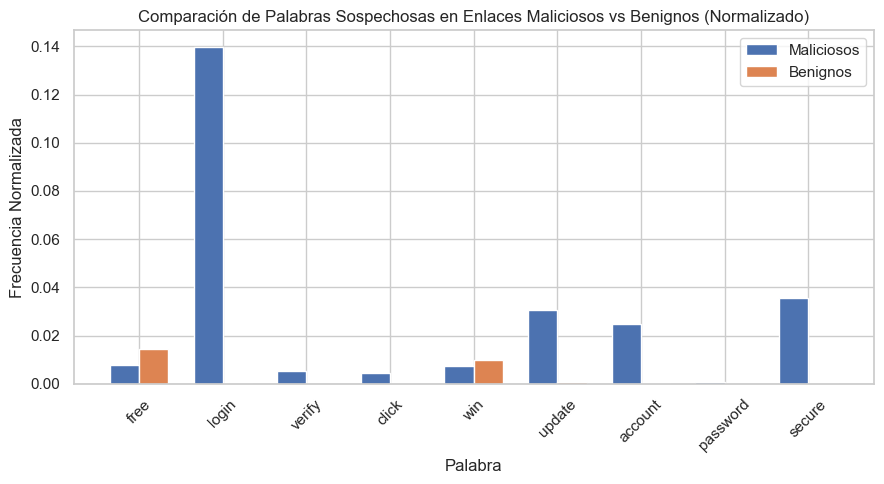

In [113]:
# Contar las palabras sospechosas en enlaces maliciosos
counts_bad = {word: df[df['Label'] == 'bad']['URL'].str.contains(word, case=False, na=False).sum() for word in suspicious_words}

# Contar las palabras sospechosas en enlaces benignos
counts_good = {word: df[df['Label'] == 'good']['URL'].str.contains(word, case=False, na=False).sum() for word in suspicious_words}

# Convertir los resultados a DataFrame
df_bad = pd.DataFrame(counts_bad.items(), columns=['Word', 'Bad Count'])
df_good = pd.DataFrame(counts_good.items(), columns=['Word', 'Good Count'])

# Normalizar los conteos
total_bad = df[df['Label'] == 'bad'].shape[0]
total_good = df[df['Label'] == 'good'].shape[0]

df_bad['Bad Count Normalized'] = df_bad['Bad Count'] / total_bad
df_good['Good Count Normalized'] = df_good['Good Count'] / total_good

# Unir los dos DataFrames
df_comparison = pd.merge(df_bad[['Word', 'Bad Count Normalized']], 
                         df_good[['Word', 'Good Count Normalized']], 
                         on='Word')

# Graficar
plt.figure(figsize=(9, 5))
x = range(len(df_comparison))
width = 0.35

plt.bar([i - width/2 for i in x], df_comparison['Bad Count Normalized'], width, label="Maliciosos")
plt.bar([i + width/2 for i in x], df_comparison['Good Count Normalized'], width, label="Benignos")

plt.xticks(x, df_comparison['Word'], rotation=45)
plt.title("Comparación de Palabras Sospechosas en Enlaces Maliciosos vs Benignos (Normalizado)")
plt.xlabel("Palabra")
plt.ylabel("Frecuencia Normalizada")
plt.legend()
plt.tight_layout()
plt.show()

Al comparar los enlaces maliciosos con los benignos, vemos que la mayoría de palabras que se utilizan en los maliciosos no son habituales en los enlaces benignos, por lo que estas palabras podrían ser un importante indicador a la hora de acceder a una página web o de clasificar un enlace como malicioso.

<Figure size 800x500 with 0 Axes>

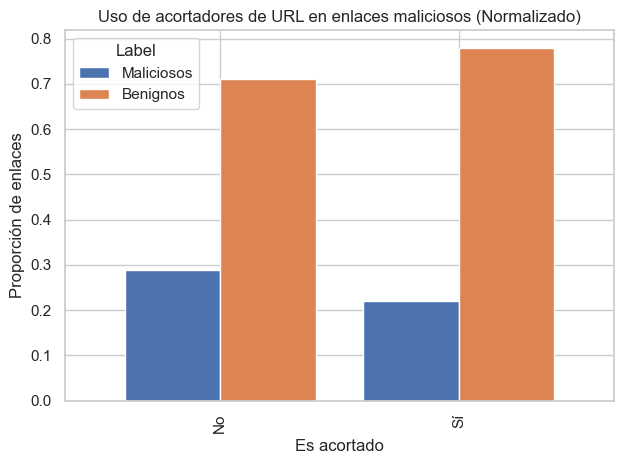

In [127]:
df_normalized = df.groupby(['is_shortened', 'Label']).size().unstack().fillna(0)
df_normalized = df_normalized.div(df_normalized.sum(axis=1), axis=0)  # Normalizar por cada categoría de is_shortened

# Graficar el gráfico de barras con las proporciones
plt.figure(figsize=(8, 5))
df_normalized.plot(kind='bar', stacked=False, width=0.8)

# Personalizar el gráfico
plt.title("Uso de acortadores de URL en enlaces maliciosos (Normalizado)")
plt.xlabel("Es acortado")
plt.ylabel("Proporción de enlaces")
plt.xticks([0, 1], ["No", "Sí"])
plt.legend(title='Label', labels=['Maliciosos', 'Benignos'])
plt.tight_layout()
plt.show()

Por último, se consideró la posibilidad de que en los enlaces maliciosos se utilicen acortadores con el objetivo de ocultar redirecciones o cualquier signo que pueda ser sospechoso a ojos de la víctima o del firewall. Sin embargo, en este caso tampoco se han obtenido los resultados esperados, ni tampoco concluyentes, por lo que esta variable no sería un indicador significativo a la hora de generar un modelo.

# Creación de modelo

A continuación, de manera completamente experimental para complementar el entregable se procede a utilizar algunas de las características de las URLs analizadas anteriormente para observar si son determinantes a la hora de generar diferentes modelos.

#### Regresión Logística

In [153]:
# Feature Engineering (Extracción de Características)
def extract_features(url):
    features = {}
    features['length'] = len(url)  # Longitud de la URL
    features['num_digits'] = sum(c.isdigit() for c in url)  # Número de dígitos
    features['num_letters'] = sum(c.isalpha() for c in url)  # Número de letras
    features['num_special_chars'] = sum(not c.isalnum() for c in url)  # Caracteres especiales
    features['num_subdomains'] = url.count('.')  # Número de puntos en el dominio
    
    # Contar caracteres específicos
    for char in ['-', '_', '/', '.', '=', '?', '&']:
        features[f'count_{char}'] = url.count(char)

    # Presencia de palabras sospechosas
    suspicious_words = ['free', 'login', 'verify', 'click', 'win', 'update', "account", "password", "secure"]
    for word in suspicious_words:
        features[f'has_{word}'] = 1 if word in url.lower() else 0

    # Extraer extensiones
    match = re.search(r'\.([a-z]{2,})$', url)
    features['extensions'] = match.group(1) if match else 'other'

    return features

# Aplicar extracción de características
feature_data = df['URL'].apply(extract_features).apply(pd.Series)

# Convertir 'extensions' a valores numéricos
le = LabelEncoder()
feature_data['extensions'] = le.fit_transform(feature_data['extensions'])

# Agregar etiquetas
feature_data['Label'] = df['Label'].map({'bad': 1, 'good': 0})  # Convertir etiquetas a 1 y 0


# Convertir 'extensions' a valores numéricos
le = LabelEncoder()

# Verificar que la columna 'extensions' esté presente
print(feature_data[['extensions', 'Label']].head())

# Regresión Logística
X = feature_data.drop(columns=['Label'])
y = feature_data['Label']

# Agregar constante para regresión logística
X_const = sm.add_constant(X)

# Ajustar modelo
model = sm.Logit(y, X_const)
result = model.fit()

# Mostrar coeficientes y significancia
print(result.summary())

   extensions  Label
0        1079      1
1        1133      1
2        1079      1
3         671      1
4        1079      1
Optimization terminated successfully.
         Current function value: 0.458802
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  Label   No. Observations:               549346
Model:                          Logit   Df Residuals:                   549324
Method:                           MLE   Df Model:                           21
Date:                Sun, 23 Mar 2025   Pseudo R-squ.:                  0.2320
Time:                        22:00:58   Log-Likelihood:            -2.5204e+05
converged:                       True   LL-Null:                   -3.2817e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

#### Conclusiones del modelo de regresión logística

##### 1. Coeficientes de las variables:
Longitud de la URL (length): Las URLs más largas tienden a ser maliciosas, con un coeficiente positivo (0.5252). Esto significa que, en general, una mayor longitud está asociada con una mayor probabilidad de ser una URL maliciosa. Este resultado es estadísticamente significativo (p = 0.007).

Número de dígitos (num_digits): Un número mayor de dígitos en la URL está relacionado con una mayor probabilidad de ser una URL benigno, aunque el coeficiente es negativo (-0.4488) y el valor p (0.075) está cerca del umbral de significancia, lo que hace que esta relación no sea tan fuerte.

Número de letras (num_letters): Un mayor número de letras está asociado con URLs benignas, ya que el coeficiente es negativo (-0.5101) y el valor p (0.011) es significativo.

Número de caracteres especiales (num_special_chars): Las URLs con más caracteres especiales tienden a ser benignas, con un coeficiente negativo (-0.6139) y un valor p altamente significativo (0.001).

Número de subdominios (num_subdomains): Aunque el coeficiente es positivo (0.2416), el valor p es extremadamente alto (1.000), lo que indica que esta variable no tiene impacto significativo en la clasificación de las URLs.

##### 2. Presencia de palabras sospechosas:
Palabras clave como has_free, has_login, has_verify, has_click, has_update, has_account, has_password, has_secure: La presencia de estas palabras en la URL tiene un impacto fuerte y significativo en la probabilidad de que una URL sea maliciosa. En particular, has_login (coef. 6.0255), has_verify (coef. 5.8701) y has_update (coef. 3.9283) tienen coeficientes muy altos, lo que indica que estas palabras son fuertes indicadores de URL maliciosas.

Palabra has_win: Aunque el coeficiente es negativo (-0.0706), es marginalmente significativo (p = 0.083), lo que sugiere que la presencia de la palabra "win" podría estar ligeramente asociada con URLs benignas.

##### 3. Características relacionadas con los caracteres específicos:
Las variables relacionadas con caracteres específicos como count_-, count__, count_/, count_., count_? y count_& no tienen un impacto significativo en el modelo. Algunos de estos valores están marcados como nan, lo que indica que estas variables no aportan información útil para la clasificación.

##### 4. Variable extensions (extensiones de dominio):
La extensión de la URL tiene un coeficiente pequeño pero positivo (0.0012), lo que indica que algunas extensiones podrían estar ligeramente asociadas con la probabilidad de que la URL sea maliciosa, pero su impacto es bastante bajo.

##### 5. Evaluación del modelo:
El Pseudo R-squared del modelo es 0.2320, lo que indica que el modelo explica aproximadamente el 23% de la variabilidad en la clasificación de las URLs (maliciosas vs benignas).

El modelo es relativamente bueno en distinguir entre las clases, pero no explica la totalidad de la variabilidad en los datos.

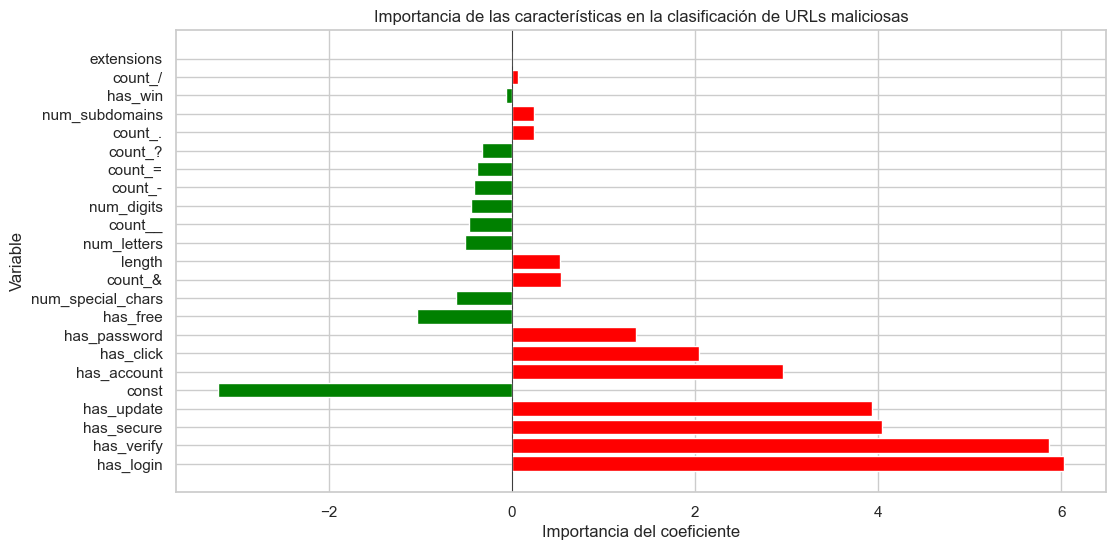

In [164]:
# Extraer coeficientes y nombres de variables
coef = result.params
features = coef.index

# Ordenar por magnitud absoluta para destacar los más relevantes
coef_sorted = coef.abs().sort_values(ascending=False)
features_sorted = coef_sorted.index

# Crear gráfico
plt.figure(figsize=(12,6))
plt.barh(features_sorted, coef[features_sorted], color=['red' if c > 0 else 'green' for c in coef[features_sorted]])
plt.xlabel("Importancia del coeficiente")
plt.ylabel("Variable")
plt.title("Importancia de las características en la clasificación de URLs maliciosas")
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

Los factores que aumentan la probabilidad de ser una URL maliciosa se muestran en rojo y los factores que disminuyen la probabilidad de ser una URL maliciosa se muestran en verde.

#### Árboles de Decisión para reglas

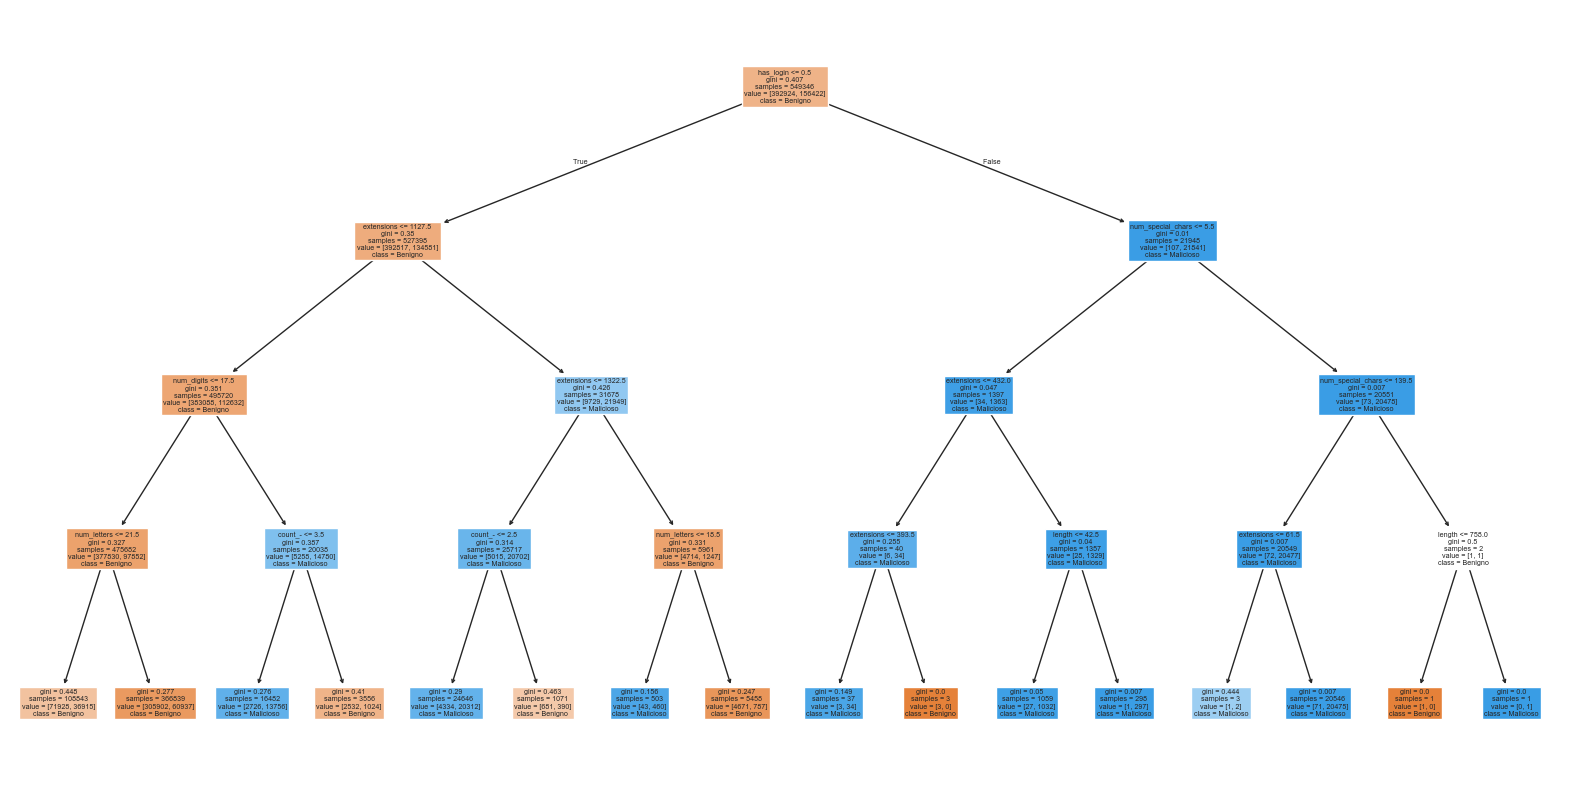

In [180]:
# Entrenar árbol de decisión
tree_model = DecisionTreeClassifier(max_depth=4)
tree_model.fit(X, y)

# Graficar árbol de decisión
plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=X.columns, class_names=['Benigno', 'Malicioso'], filled=True)
plt.show()

Para evitar el sobreajuste de los datos, se ha establecido el nivel de profundidad del árbol en 4, aunque podría realizarse un estudio sobre qué profunidad es mejor en este modelo para los datos. También sería interesante el uso de random forest para un mejor ajuste de la clasificación.
El índice Gini de algunas hojas cercano a 0 indica que hay una clara separación de las clases. Algunos de los factores clave de decisión para una correcta clasificación de los enlaces son:
- "has_login": Si el software tiene una función de inicio de sesión, es más probable que sea benigno.
- "num_special_chars": Un uso excesivo de caracteres especiales en los archivos o código puede indicar que el enlace es malicioso.
- "num_digits" y "num_letters": La cantidad de letras y números en nombres de archivos o código también influye en la clasificación de forma significativa.

# Resumen de los resultados y conclusiones finales
- Las palabras clave como "login", "verify", "update", y "secure" son fuertes indicadores de URLs maliciosas.
- Las URLs más largas y con más caracteres especiales tienden a ser más benignas.
- El modelo presenta un desempeño razonable, pero podría beneficiarse de más características o técnicas de modelado adicionales.
- Aunque la extensión de las URLs tiene un impacto pequeño, su influencia es significativa.

Hubiese sido muy interesante probar con otros modelos, explorar otras variables que puedan ser significativas a la hora de realizar predicciones o integrar estos datos con otro dataset como por ejemplo una base de datos procedente del MISP, que además esté actualizada a nuevos enlaces maliciosos comunmente utilizados por atacantes, ya que el mundo de la ciberseguridad es cambiante y debemos mantenernos al día. De momento, aquí se da por concluido este pequeño estudio, siendo consciente de todo el abanico de posibilidades que tiene y en el que a futuro seguiré explorando.